# DBSCAN
This notebook uses DBSCAN as a clustering density based approach.



DBSCAN is quite an expensive algorithm to use and given the difficult in finding good clusters so a reduction of some kind is needed, we could use two kind first a reduction in dimensionality by preprocessing some features and then random sampling to make everything executable and with reasonable times.

In [15]:
import datetime
from sklearn.cluster import DBSCAN
from os import path
import pandas as pd
from sklearn.preprocessing import StandardScaler
import utils
from scipy.sparse import csr_matrix

RACES_PATH=path.join("..","dataset","engineered_races.csv")
races_df=pd.read_csv(RACES_PATH)

num_columns = [
            'points',
            'length',
            'climb_total',
            'profile',
            'startlist_quality',
            'position',
            'cyclist_age',
            'delta',
            'climbing_efficiency',
            'competitive_age',
            'difficulty',
            'convenience_score',
            'difficulty_score',
            'performance_index',
            'gain_ratio',
 ]
data_df=races_df[num_columns].drop_duplicates()
data_df=races_df.groupby(['cyclist','std_name']).apply(lambda x: x.sample(n=1, random_state=42)).reset_index(drop=True)

/tmp/ipykernel_37018/214684709.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_df=races_df.groupby(['cyclist','std_name']).apply(lambda x: x.sample(n=1, random_state=42)).reset_index(drop=True)


In [ ]:
print(f"the dataset has {data_df.shape[0]} samples with {data_df.shape[1]} features")

the dataset has 41449 samples with 22 features


: 

# bulk clustering
A first trial is done using the whole dataset and we can then think of segmentations using the domain to see if there is any significant difference, however as starting point we are gonna need to determine the initial parameters.

So the hardest part is picking the $MinPts$ parameter since $Eps$ is easy to determine after finding it. From the laboratories we can start by using $2D$ which at least takes into account dimensionality and test values in the range $[2D,(\text{dataset\_size}-1)]$, we need a good balance between a thorough research for minpts without wasting time on parameters first we check our dataset dimensionality and its size for measure of scales.

In [2]:
%xmode Verbose
from sklearn.neighbors import NearestNeighbors
import utils
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.sparse import csr_matrix
from kneed import KneeLocator

std_scaler=StandardScaler()
#the whole dataset is numeric
std_data=std_scaler.fit_transform(utils.random_sampling_reduce(data_df[num_columns].drop_duplicates(),0.5))

print(type(std_data))
min_pts=std_data.shape[0]-1
nn=NearestNeighbors(n_neighbors=min_pts,n_jobs=-1,algorithm='ball_tree').fit(std_data)
distances,indices= nn.kneighbors(std_data,n_neighbors=min_pts)

Exception reporting mode: Verbose
<class 'numpy.ndarray'>


Given that we don't hav much information about the density which is important we can employ the kneedle algorithm to be able to determine eps without wasting time doing each timethe manual elbow method application through the visual plot. We will focus instead on finding good values for minpts wich is much more important, we need some sort of heuristic to set it, one starting point is double the dimensionality however it is not optimal we also need to take into consideration some the number of entries in the dataset of some kind, a nice idea could be to estimate percentages and see waht happens using a certai percentage of the dataset given the high number of features.

In [4]:
import math

sorted_dists=[]

n_dim=std_data.shape[1]
n_size=std_data.shape[0]

kth_neighbors=[
    {
        'minpts':math.ceil(n_size*0.01),
    },
    {
        'minpts':math.ceil(n_size*0.02),
    },
    {
        'minpts':math.ceil(n_size*0.3),
    },
    {
        'minpts':math.ceil(n_size*0.04),
    },
    {
        'minpts':math.ceil(n_size*0.05),
    },
    {
        'minpts':math.ceil(n_size*0.06),
    },
    {
        'minpts':math.ceil(n_size*0.07),
    },
    {
        'minpts':math.ceil(n_size*0.08),
    },
    {
        'minpts':math.ceil(n_size*0.09),
    },
    {
        'minpts':math.ceil(n_size*0.1),
    },
]
def round_to_next_decimal(value):
    return math.ceil(value * 100) / 100

for kth in kth_neighbors:  
    k_distances= np.sort(distances[:,kth['minpts']-1])
    kneedle=KneeLocator(x=range(1,len(k_distances)+1),y=k_distances,S=7000,curve="convex",direction="increasing")
    kth['eps']= round_to_next_decimal(round(kneedle.elbow_y,5))
    print("eps by knee x",kneedle.elbow,"y",kth['eps'],"with minpts",kth['minpts'])
    sorted_dists.append(k_distances)

eps by knee x 19750 y 3.56 with minpts 208
eps by knee x 19260 y 3.78 with minpts 415
eps by knee x 18746 y 5.44 with minpts 6218
eps by knee x 19265 y 4.31 with minpts 829
eps by knee x 19262 y 4.46 with minpts 1037
eps by knee x 19280 y 4.62 with minpts 1244
eps by knee x 17939 y 4.03 with minpts 1451
eps by knee x 19302 y 4.85 with minpts 1658
eps by knee x 18970 y 4.68 with minpts 1866
eps by knee x 19018 y 4.79 with minpts 2073


After trying the intial value and varying it with on an exponential scale we see that more or less or each plot we always get an elbow on the same spot thus we use the eps value to start out dbscan algorithm there.

The eps values changes but no too much at differet scales, it just grows with the number of eps an idea to start grid search then is to set a range made of the values and use that to narrow down the initial range. the values for eps will be the ones we tried above.

In [5]:
import itertools as it
#useful to estimatethe density of the dataset
maximum_distance=abs(std_data.max()-std_data.min()).sum().item()
average_concentration= std_data.shape[0]/maximum_distance

print(f"""
maximum distance : {maximum_distance}
average concentration : {average_concentration}
""")

min_pts_list=[ e['minpts'] for e in kth_neighbors ]
eps_list=[ e['eps'] for e in kth_neighbors ]


results_df=utils.run_dbscan(
    min_pts_values=min_pts_list,
    eps_values=eps_list,
    metric=['euclidean'],
    clustering_data=std_data
)

results_df


maximum distance : 88.50267684104764
average concentration : 234.1737079571329

Running DBSCAN: 0 - eps=3.56, metric=euclidean, min_samples=208
DBSCAN done in 13.89 seconds | Silhouette Score: 0.9062458007352263
Running DBSCAN: 1 - eps=3.56, metric=euclidean, min_samples=415
DBSCAN done in 12.57 seconds | Silhouette Score: 0.9062458007352263
Running DBSCAN: 2 - eps=3.56, metric=euclidean, min_samples=6218
DBSCAN done in 11.99 seconds | Silhouette Score: 0.9062458007352263
Running DBSCAN: 3 - eps=3.56, metric=euclidean, min_samples=829
DBSCAN done in 11.84 seconds | Silhouette Score: 0.9062458007352263
Running DBSCAN: 4 - eps=3.56, metric=euclidean, min_samples=1037
DBSCAN done in 11.93 seconds | Silhouette Score: 0.9062458007352263
Running DBSCAN: 5 - eps=3.56, metric=euclidean, min_samples=1244
DBSCAN done in 12.32 seconds | Silhouette Score: 0.9062458007352263
Running DBSCAN: 6 - eps=3.56, metric=euclidean, min_samples=1451
DBSCAN done in 12.85 seconds | Silhouette Score: 0.90624580

group_index   eps     metric  min_samples  silhouette_score  \
0             0  3.56  euclidean          208          0.906246   
0             1  3.56  euclidean          415          0.906246   
0             2  3.56  euclidean         6218          0.906246   
0             3  3.56  euclidean          829          0.906246   
0             4  3.56  euclidean         1037          0.906246   
..          ...   ...        ...          ...               ...   
0            95  4.79  euclidean         1244          0.906246   
0            96  4.79  euclidean         1451          0.906246   
0            97  4.79  euclidean         1658          0.906246   
0            98  4.79  euclidean         1866          0.906246   
0            99  4.79  euclidean         2073          0.906246   

    execution_time(s)  
0           13.885059  
0           12.572970  
0           11.985092  
0           11.835439  
0           11.927378  
..                ...  
0           12.748611  
0           13.436785  
0           12.011815  
0           12.197509  
0           12.235336  

[100 rows x 6 columns]

From this first coarse grained clustering we obtained a pretty high silhoutte score however it is the same this suggests that we could try to reduce it using lower values of eps to obtain tighter clusters.

In [8]:
usable_results=results_df.loc[~((results_df['silhouette_score']=='all noise') | (results_df['silhouette_score']=='all core'))]


usable_results.sort_values(by=['silhouette_score','min_samples','eps'],ascending=[False,True,True])

group_index   eps     metric  min_samples  silhouette_score  \
0             0  3.56  euclidean          208          0.906246   
0            10  3.78  euclidean          208          0.906246   
0            60  4.03  euclidean          208          0.906246   
0            30  4.31  euclidean          208          0.906246   
0            40  4.46  euclidean          208          0.906246   
..          ...   ...        ...          ...               ...   
0            52  4.62  euclidean         6218          0.906246   
0            82  4.68  euclidean         6218          0.906246   
0            92  4.79  euclidean         6218          0.906246   
0            72  4.85  euclidean         6218          0.906246   
0            22  5.44  euclidean         6218          0.906246   

    execution_time(s)  
0           13.885059  
0           13.181863  
0           12.460026  
0           12.919936  
0           12.731035  
..                ...  
0           13.222373  
0           12.458057  
0           12.635092  
0           13.006976  
0           12.889199  

[100 rows x 6 columns]

Such a value is not expected and could be due to heavy sampling made in order to reduce the computational complexity of the algorithm, this is meant as a first trial tounderstand better the dataset.

So using that we can group the labels with cores,borders and noise to visualize better what is happening.


results:{'eps': 3.56, 'min_samples': 208}
statistics:
    noise 158
    core 20567
    border None

{'noise': 0.007623642943305187, 'core': 0.9923763570566948, 'border': 0}


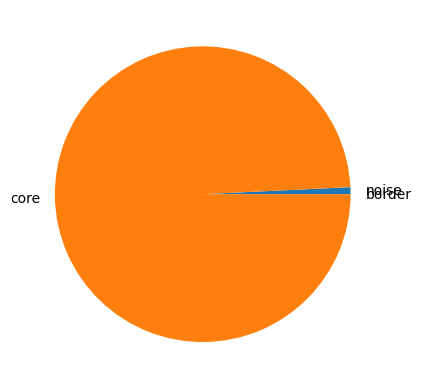

In [3]:
import datetime
from sklearn.cluster import DBSCAN
from os import path
import pandas as pd
from sklearn.preprocessing import StandardScaler
import utils
from scipy.sparse import csr_matrix

best_idx=0
#best_params=usable_results.iloc[best_idx]
best_params={
    'eps':3.56,
    'min_samples':208
}
best_dbscan=DBSCAN(eps=best_params['eps'],min_samples=best_params['min_samples']).fit(std_data)

labels=best_dbscan.labels_

statistics=np.unique(best_dbscan.labels_,return_counts=True)

print(
f"""
results:{best_params}
statistics:
    noise {statistics[1][0]}
    core {statistics[1][1]}
    border {statistics[1][2] if len(std_data[1])==3 else None}
"""
)


cluster_info={
    'noise':statistics[1][0]/len(labels),
    'core':statistics[1][1]/len(labels),
    'border':statistics[1][2]/len(labels) if len(std_data[1])==3 else 0,
}

plt.pie(cluster_info.values(),labels=cluster_info.keys())
print(cluster_info)

Given the dimensionality a first idea could be a pairwise plot for all the values inside the dataset as to get a idea.



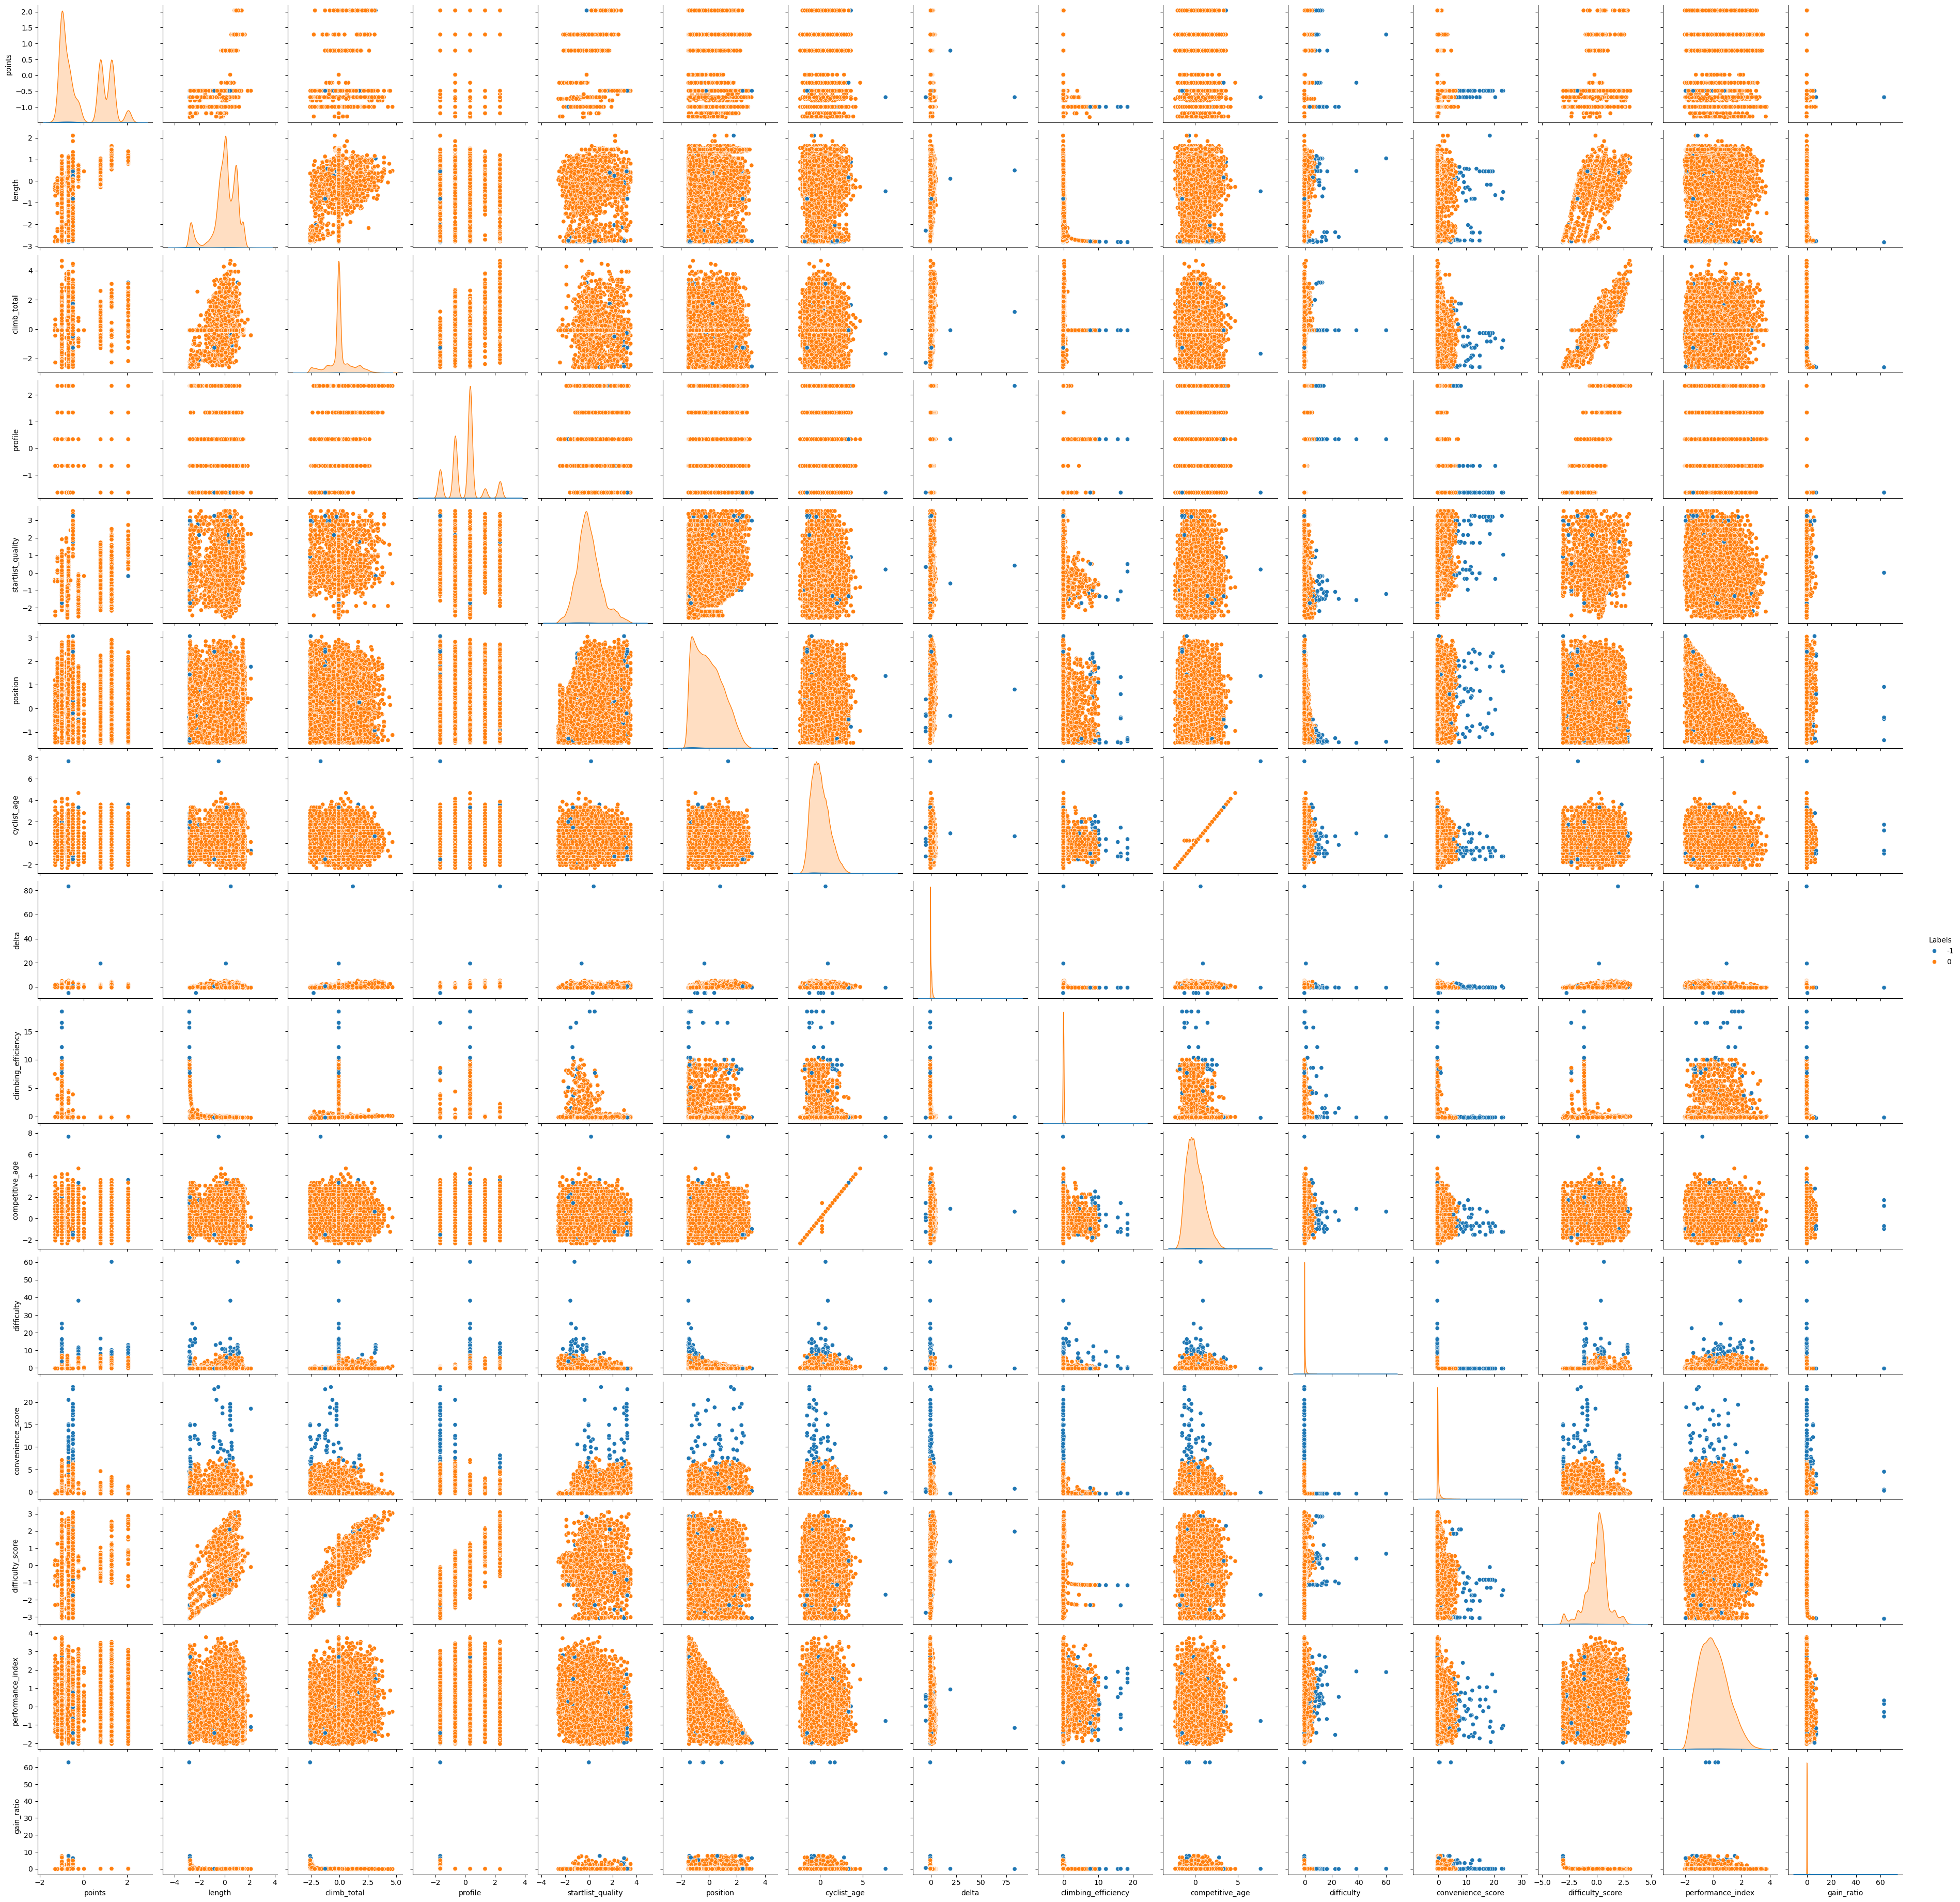

In [7]:
import seaborn as sns

df=pd.DataFrame(std_data,columns=num_columns)
df['Labels'] = labels

# Map labels to colors
# Seaborn will automatically handle -1 (noise) by assigning a color
palette = sns.color_palette("tab10", n_colors=len(set(labels)))
hue_order = sorted(set(labels))  # Ensure noise (-1) is handled correctly
sns.pairplot(df,hue='Labels',palette=palette,hue_order=hue_order,diag_kind='kde')

So in ths case we see a single cluster, given the computational drain it is not possible to further enhance such analysis however we can still see that outliers are well out of the defined but not for all pairs, so we can imply that some features are less correlated most notably all the values correlated with difficulty_score and convenience_score tend to show such behavior while all the other pairs have some noise within their respective cluster grouping while others have some noise that is way out of the distribution and is for from its group.

# segmentation

given the first trial it is not possible to continue withot taking advtange of the domain thus we have to employ semantical segmentation and we can also use the previous hyperparametres space and kneedle algorithm to do more clustering analysis, in this case we should be reducing the size notably and should be also able to have much more meaningful clusters.

## profile segmentation

A first useful segmentation we could employ is by profile to understand if there are significant differences from the different clusters.

In [14]:
races_df.groupby('profile').count()
def dbscan_hyperparam_search(kth_neighbors,distances,s_value=7000):
    for kth in kth_neighbors:  
        k_distances= np.sort(distances[:,kth['minpts']-1])
        kneedle=KneeLocator(x=range(1,len(k_distances)+1),y=k_distances,S=s_value,curve="convex",direction="increasing")
        kth['eps']= round_to_next_decimal(round(kneedle.elbow_y,5))
        print("eps by knee x",kneedle.elbow,"y",kth['eps'],"with minpts",kth['minpts'])
        sorted_dists.append(k_distances)
    return kth_neighbors

#dbscan_hyperparam_search(kth_neighbors)

std_scaler=StandardScaler()

segmentation_values=[]

for g,idxs in races_df[num_cols].groupby('profile').groups.items():

    std_data=std_scaler.fit_transform(g)
    min_pts=std_data.shape[0]-1
    nn=NearestNeighbors(n_neighbors=min_pts,n_jobs=-1,algorithm='ball_tree').fit(std_data)
    distances,indices= nn.kneighbors(std_data,n_neighbors=min_pts)

    results=dbscan_hyperparam_search(kth_neighbors,distances)
    segmentation_values.append(results)




NameError: name 'num_cols' is not defined

In [40]:
import networkx as nx
def extract_connected_components(core_points,eps):

    # Create a graph to connect core points
    G = nx.Graph()

    # Add core points as nodes
    for i, point in enumerate(core_points):
        G.add_node(i, pos=point)

    # Add edges between neighboring core points
    nbrs = NearestNeighbors(radius=eps).fit(core_points)
    distances, indices = nbrs.radius_neighbors(core_points)

    for i, neighbors in enumerate(indices):
        for j in neighbors:
            if i != j:  # Avoid self-loops
                G.add_edge(i, j)

    # Extract connected components (clusters)
    connected_components = list(nx.connected_components(G))

    return connected_components

core_clusters=extract_connected_components(core_samples,best_params['eps'])

: 

As you can see clustyring by years even after trying to reduce the dimension to get less sparse clusters is not effective, aside from a nice 0.71 in the first part we cannot get much more than that, we can infer very different densities across years which makes for very bad clusterings.

So we can try other kind of segmentations, a first approach could be geospatial: group by the race occurencies across time.

## geospatial clustering

In [2]:
ohe_diff_lvl=pd.get_dummies(races_df['difficulty_level']).astype(float)
clustering_data[ohe_diff_lvl.columns]=ohe_diff_lvl

ohe_tarmac=pd.get_dummies(races_df['is_tarmac']).astype(float)

cols=list(ohe_tarmac.columns)
cols[0]='True_is_tarmac'
cols[1]='False_is_tarmac'
clustering_data[cols]=ohe_tarmac


clustering_data=clustering_data.drop(columns=["cyclist","cyclist_team","is_tarmac","difficulty_level","date","stage"]).drop_duplicates()

std_scaler=StandardScaler()

clustering_data=utils.random_sampling_reduce(clustering_data,0.25)

races_groups=clustering_data.groupby('std_name')
normalized_races_groups={k:std_scaler.fit_transform(g.drop(columns="std_name").drop_duplicates()) for k,g in races_groups }

print({k:len(g) for k,g in normalized_races_groups.items()})

initial_eps=dict()

kth_neighbor=4

for k,data in normalized_races_groups.items():
    min_pts=data.shape[1]
    nn=NearestNeighbors(n_neighbors=min_pts-1,n_jobs=-1)
    nn.fit(data)
    distances,indices= nn.kneighbors(data)
    k_distances= np.sort(distances[:, -1])

    initial_eps[k]=k_distances[kth_neighbor-1]


print(f"""
number of groups={len(normalized_races_groups)}
initial eps values per group={initial_eps}
""")

{'amstel-gold-race': 1108, 'dauphine': 6671, 'dwars-door-vlaanderen': 648, 'e3-harelbeke': 821, 'giro-d-italia': 23911, 'gp-montreal': 269, 'gp-quebec': 327, 'gran-camino': 175, 'il-lombardia': 749, 'itzulia-basque-country': 4528, 'la-fleche-wallone': 1271, 'liege-bastogne-liege': 1190, 'milano-sanremo': 1638, 'omloop-het-nieuwsblad': 1005, 'paris-nice': 8011, 'paris-roubaix': 909, 'ronde-van-vlaanderen': 1076, 'san-sebastian': 1168, 'strade-bianche': 304, 'tirreno-adriatico': 6844, 'tour-de-france': 36613, 'tour-de-romandie': 4985, 'tour-de-suisse': 8383, 'uae-tour': 1072, 'volta-a-catalunya': 6528, 'vuelta-a-espana': 26282, 'world-championship': 949}

number of groups=27
initial eps values per group={'amstel-gold-race': 1.331096502661081, 'dauphine': 0.8401145858418447, 'dwars-door-vlaanderen': 1.2632881010334707, 'e3-harelbeke': 1.3823696824421974, 'giro-d-italia': 0.7261308576322284, 'gp-montreal': 2.0184520099061922, 'gp-quebec': 1.882460185176687, 'gran-camino': 2.48516596897522,

In [3]:
import gc

group_results=pd.DataFrame()
for k,decade_data in normalized_races_groups.items():
    #NOTE: this might have to be revisited for it's just to try if everyting works
    dimension=decade_data.shape[0]
    min_pts=int(dimension-1)
    #using the method seen at laboratory to select initial values
    #print(decade_data.drop(columns="decade").info())
    maximum_distance = abs(decade_data.max() - decade_data.min()).sum().item()
    average_concentration = dimension / maximum_distance
    #use diferent scales for eps values
    # during the tests a lot of low values where not taken into consideration
    eps_values=initial_eps[k] * np.array([500,250,100,50,10, 5, 2.5, 1, 0.1, 0.01, 0.0001])
    #try various metrics
    metrics=['euclidean']

    min_pts_values=[min_pts]
    print(
    f"""
    period {k}
    maxium distance: {maximum_distance}
    average concentration:{average_concentration}
    eps values:{eps_values}
    used metrics:{metrics}
    number of minimum samples:{min_pts}
    number of samples used:{decade_data.shape[0]}
    """
    )
    gc.collect()
    #normalization is done for each group
    result=utils.run_dbscan(min_pts_values,eps_values,metrics,decade_data)
    result["group"]=k
    group_results=pd.concat([group_results,result])
group_results.reset_index()


    period amstel-gold-race
    maxium distance: 13.372756617282896
    average concentration:82.85501873024634
    eps values:[6.65548251e+02 3.32774126e+02 1.33109650e+02 6.65548251e+01
 1.33109650e+01 6.65548251e+00 3.32774126e+00 1.33109650e+00
 1.33109650e-01 1.33109650e-02 1.33109650e-04]
    used metrics:['euclidean']
    number of minimum samples:1107
    number of samples used:1108
    
Running DBSCAN: 0 - eps=665.5482513305406, metric=euclidean, min_samples=1107
DBSCAN done in 0.02 seconds | Silhouette Score: all noise
Running DBSCAN: 1 - eps=332.7741256652703, metric=euclidean, min_samples=1107
DBSCAN done in 0.02 seconds | Silhouette Score: all noise
Running DBSCAN: 2 - eps=133.1096502661081, metric=euclidean, min_samples=1107
DBSCAN done in 0.02 seconds | Silhouette Score: all noise
Running DBSCAN: 3 - eps=66.55482513305405, metric=euclidean, min_samples=1107
DBSCAN done in 0.02 seconds | Silhouette Score: all noise
Running DBSCAN: 4 - eps=13.31096502661081, metric=euclid

: 

# Cyclists dataset

In [13]:
import datetime
from sklearn.cluster import DBSCAN
from os import path
import pandas as pd
from sklearn.preprocessing import StandardScaler
import utils
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import itertools as it
import numpy as np
import utils

def most_frequent(series):
    return series.mode()[0] if not series.mode().empty else series.iloc[0]
CYCLISTS_PATH=path.join("..","dataset","cyclists_final_enhanced.csv")
cyclists_df=pd.read_csv(CYCLISTS_PATH)


cyclists_df=cyclists_df[['birth_year','weight','height','bmi','career_points','career_duration(days)','career_duration(races)','debut_year','avg_pos']]

In [7]:
cyclists_df

birth_year  weight  height        bmi  career_points  \
0           1964    73.0     185  21.329438           80.0   
1           1965    74.0     182  22.340297        26105.0   
2           1996    69.0     189  19.316369         4425.0   
3           1995    78.0     192  21.158854        17205.0   
4           1997    55.0     171  18.809206         3085.0   
...          ...     ...     ...        ...            ...   
6090        1966    62.0     179  19.350208           80.0   
6091        1998    75.0     188  21.220009         2410.0   
6092        1973    67.0     181  20.451146          955.0   
6093        1985    58.0     170  20.069204         8920.0   
6094        1999    75.0     186  21.678807         2125.0   

      career_duration(days)  career_duration(races)  debut_year     avg_pos  
0                       1.0                     1.0      1989.0  110.000000  
1                    3492.0                   222.0      1988.0   63.545045  
2                     519.0                    49.0      2022.0   87.693878  
3                    1982.0                   161.0      2018.0   83.242236  
4                     721.0                    48.0      2021.0   68.000000  
...                     ...                     ...         ...         ...  
6090                    1.0                     1.0      1993.0   10.000000  
6091                 1140.0                    26.0      2020.0   84.576923  
6092                  311.0                    12.0      1997.0  106.500000  
6093                 1849.0                   113.0      2009.0   71.929204  
6094                  745.0                     9.0      2021.0   69.444444  

[6095 rows x 9 columns]

6050 1.61499502886297


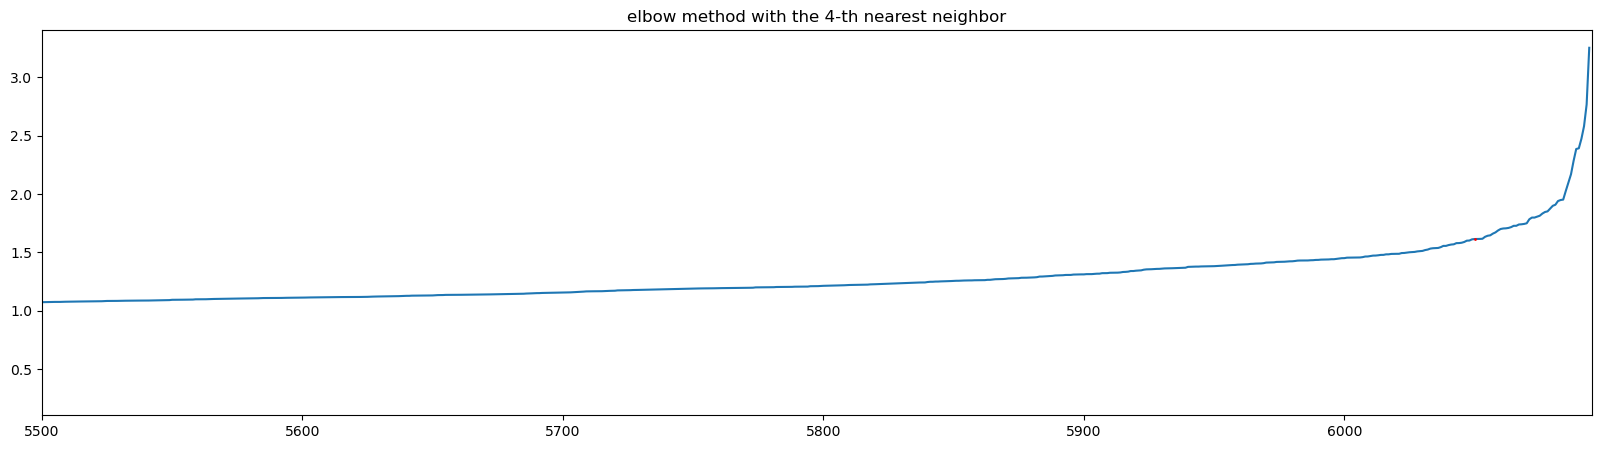

6050 1.6880263399197046


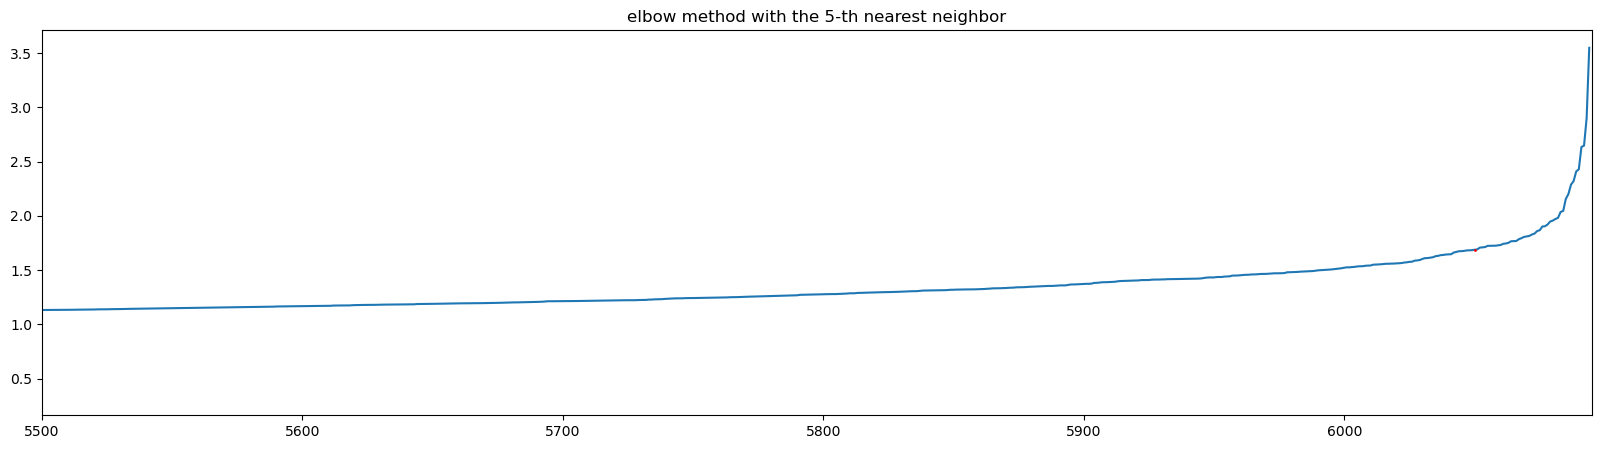

6050 1.9649075593573622


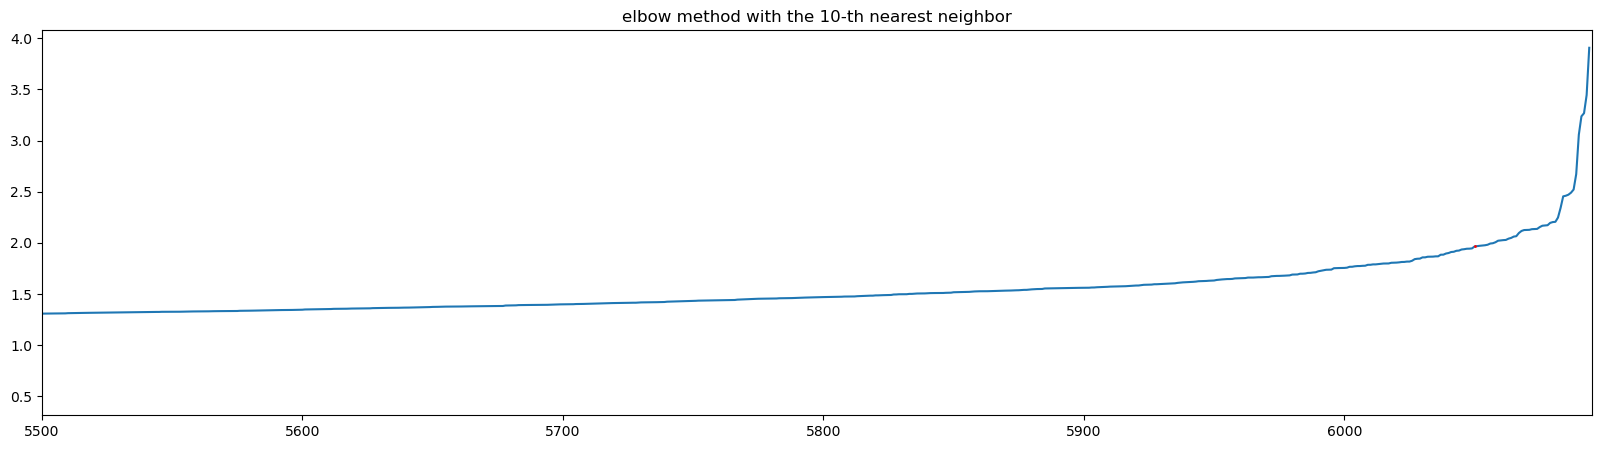

6050 2.9309918869440366


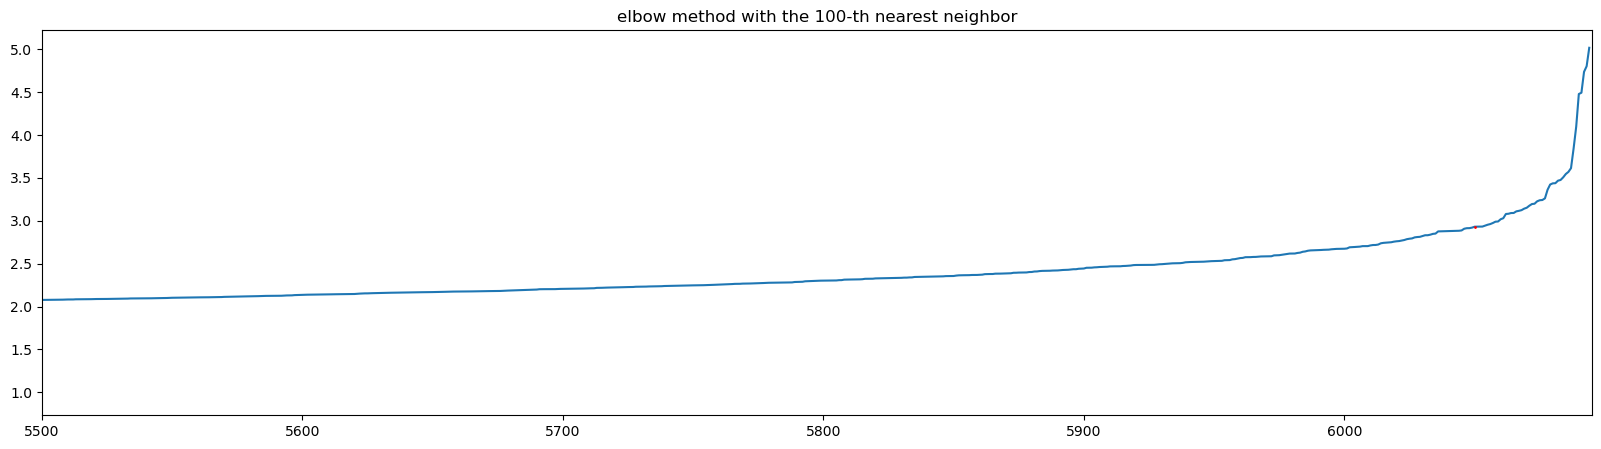

6050 5.410020009063454


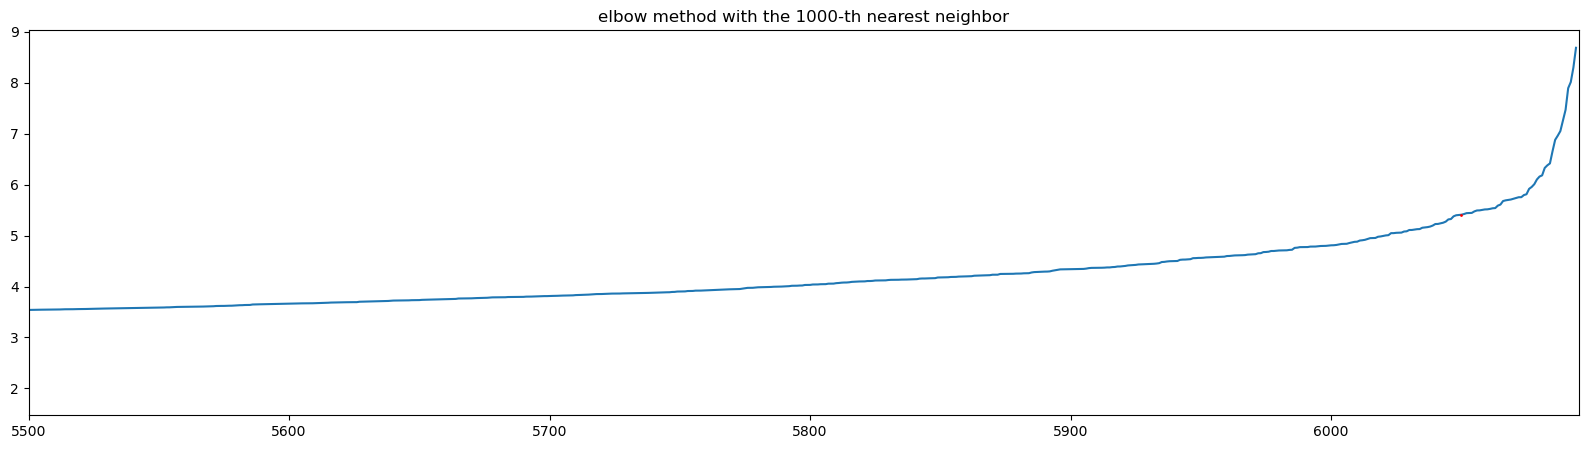

In [25]:
import numpy as np
import matplotlib.pyplot as plt

std_scaler=StandardScaler()
norm_data=std_scaler.fit_transform(cyclists_df)

min_pts=norm_data.shape[0]




nn=NearestNeighbors(n_neighbors=min_pts,n_jobs=-1).fit(norm_data)
distances,indices= nn.kneighbors(norm_data,n_neighbors=min_pts)



sorted_dists=[]

n_dim=norm_data.shape[0]

kth_neighbors=[
    4,
    5,
    10,
    100,
    1000,

]

for k in kth_neighbors:  
    k_distances= np.sort(distances[:,k-1])
    plt.figure(figsize=(20,5))
    plt.plot(k_distances)
    plt.xlim(5500,n_dim)
    plt.plot(6050,k_distances[6050],marker='o',markersize=1,color='red')
    print(6050,k_distances[6050])
    #plt.xlim(294860,len(k_distances))
    plt.title(f"elbow method with the {k}-th nearest neighbor")
    plt.show()
    sorted_dists.append(k_distances)

In [29]:

results_df=utils.run_dbscan(
    min_pts_values=[
        4,
        5,
        10,
        1000
        ],
    eps_values=it.chain(

        1.7*np.array([10,5,2.5,1,0.1,0.01,0.0001]),
        2*np.array([10,5,2.5,1,0.1,0.01,0.0001]),
        3*np.array([10,5,2.5,1,0.1,0.01,0.0001]),
        5.5*np.array([10,5,2.5,1,0.1,0.01,0.0001])
    ),
    metric=['euclidean'],
    clustering_data=norm_data
)

results_df

Running DBSCAN: 0 - eps=17.0, metric=euclidean, min_samples=4
DBSCAN done in 0.66 seconds | Silhouette Score: -0.3981656348783065
Running DBSCAN: 1 - eps=17.0, metric=euclidean, min_samples=5
DBSCAN done in 0.59 seconds | Silhouette Score: -0.3981656348783065
Running DBSCAN: 2 - eps=17.0, metric=euclidean, min_samples=10
DBSCAN done in 0.67 seconds | Silhouette Score: -0.3981656348783065
Running DBSCAN: 3 - eps=17.0, metric=euclidean, min_samples=1000
DBSCAN done in 0.01 seconds | Silhouette Score: all noise
Running DBSCAN: 4 - eps=8.5, metric=euclidean, min_samples=4
DBSCAN done in 0.62 seconds | Silhouette Score: -0.3981656348783065
Running DBSCAN: 5 - eps=8.5, metric=euclidean, min_samples=5
DBSCAN done in 0.61 seconds | Silhouette Score: -0.3981656348783065
Running DBSCAN: 6 - eps=8.5, metric=euclidean, min_samples=10
DBSCAN done in 0.61 seconds | Silhouette Score: -0.3981656348783065
Running DBSCAN: 7 - eps=8.5, metric=euclidean, min_samples=1000
DBSCAN done in 0.01 seconds | Silh

group_index       eps     metric  min_samples silhouette_score  \
0             0  17.00000  euclidean            4        -0.398166   
0             1  17.00000  euclidean            5        -0.398166   
0             2  17.00000  euclidean           10        -0.398166   
0             3  17.00000  euclidean         1000        all noise   
0             4   8.50000  euclidean            4        -0.398166   
..          ...       ...        ...          ...              ...   
0           107   0.05500  euclidean         1000        all noise   
0           108   0.00055  euclidean            4        all noise   
0           109   0.00055  euclidean            5        all noise   
0           110   0.00055  euclidean           10        all noise   
0           111   0.00055  euclidean         1000        all noise   

    execution_time(s)  
0            0.658686  
0            0.590532  
0            0.667241  
0            0.011208  
0            0.619285  
..                ...  
0            0.013042  
0            0.012207  
0            0.010629  
0            0.012087  
0            0.012706  

[112 rows x 6 columns]

In [32]:
results_df.loc[results_df['silhouette_score']=='all noise',['silhouette_score']]=-1


results_df[results_df['silhouette_score']>=0].sort_values(by='silhouette_score',ascending=False)

results_df.sort_values(by='silhouette_score',ascending=False)

group_index       eps     metric  min_samples silhouette_score  \
0             0  17.00000  euclidean            4        -0.398166   
0            66   7.50000  euclidean           10        -0.398166   
0            36   5.00000  euclidean            4        -0.398166   
0            37   5.00000  euclidean            5        -0.398166   
0            38   5.00000  euclidean           10        -0.398166   
..          ...       ...        ...          ...              ...   
0            21   0.01700  euclidean            5               -1   
0            22   0.01700  euclidean           10               -1   
0            59  30.00000  euclidean         1000               -1   
0            23   0.01700  euclidean         1000               -1   
0           111   0.00055  euclidean         1000               -1   

    execution_time(s)  
0            0.658686  
0            0.629982  
0            0.624097  
0            0.615206  
0            0.620251  
..                ...  
0            0.008492  
0            0.010537  
0            0.008543  
0            0.011106  
0            0.012706  

[112 rows x 6 columns]